# Notebook 01: Data Preparation

**Goal**: Load the raw NBC interest rate data, extract Term Loans and Term Deposits for both currencies (KHR and USD), compute interest rate spreads, and save clean CSVs.

**Data Source**: National Bank of Cambodia — Deposit Money Banks' Interest Rates on Deposits and Loans

**Rate Type**: Weighted Average Rate on New Amount (primary) + Outstanding Amount (robustness)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

## 1. Load Raw Data

In [2]:
# Load the combined NBC data
df = pd.read_csv('/Users/dukpagnarith/Documents/Research_Reda/combined_interest_rates_long.csv', parse_dates=['Date'])

print(f"Shape: {df.shape}")
print(f"Date range: {df['Date'].min().strftime('%Y-%m')} to {df['Date'].max().strftime('%Y-%m')}")
print(f"Total months: {df['Date'].nunique()}")
print()
print("Columns:", list(df.columns))
print()
print("Unique values:")
for col in ['Currency', 'Category', 'Product', 'Rate_Type']:
    print(f"  {col}: {sorted(df[col].unique())}")

Shape: (4992, 7)
Date range: 2013-01 to 2025-12
Total months: 156

Columns: ['Date', 'Currency', 'Category', 'Product', 'Rate_Type', 'Value', 'Source']

Unique values:
  Currency: ['KHR', 'USD']
  Category: ['Deposits', 'Loans']
  Product: ['Credit Card', 'Demand Deposits', 'Other Deposits', 'Other Loans', 'Overdraft', 'Saving Deposits', 'Term Deposits', 'Term Loans']
  Rate_Type: ['Weighted Average on New Amount', 'Weighted Average on Outstanding Amount']


In [3]:
# Quick look at the data
df.head(10)

,Date,Currency,Category,Product,Rate_Type,Value,Source
0,2013-01-01,KHR,Deposits,Demand Deposits,Weighted Average on New Amount,0.140016,NBC_Excel
1,2013-01-01,KHR,Deposits,Other Deposits,Weighted Average on New Amount,0.000000,NBC_Excel
2,2013-01-01,KHR,Deposits,Saving Deposits,Weighted Average on New Amount,1.123348,NBC_Excel
3,2013-01-01,KHR,Deposits,Term Deposits,Weighted Average on New Amount,6.203495,NBC_Excel
4,2013-01-01,KHR,Loans,Credit Card,Weighted Average on New Amount,0.000000,NBC_Excel
5,2013-01-01,KHR,Loans,Other Loans,Weighted Average on New Amount,20.400000,NBC_Excel
6,2013-01-01,KHR,Loans,Overdraft,Weighted Average on New Amount,0.000000,NBC_Excel
7,2013-01-01,KHR,Loans,Term Loans,Weighted Average on New Amount,29.738981,NBC_Excel
8,2013-01-01,KHR,Deposits,Demand Deposits,Weighted Average on Outstanding Amount,0.106246,NBC_Excel
9,2013-01-01,KHR,Deposits,Other Deposits,Weighted Average on Outstanding Amount,0.000000,NBC_Excel


## 2. Extract Term Loans & Term Deposits (New Amount)

**Why these products?**
- **Term Loans**: Most representative of standard bank lending — pricing directly reflects credit risk assessment
- **Term Deposits**: Best maturity match with term loans — avoids liquidity-driven pricing of demand/saving deposits

**Why New Amount rates?**
- Reflects banks' *current* risk pricing on newly issued loans
- Responds faster to changes in risk perception than Outstanding Amount (which is diluted by legacy rates)

In [4]:
# ============================================================
# PRIMARY DATA: Weighted Average on New Amount
# ============================================================

rate_type_primary = 'Weighted Average on New Amount'

# Filter for Term Loans and Term Deposits only
mask = (
    (df['Rate_Type'] == rate_type_primary) &
    (df['Product'].isin(['Term Loans', 'Term Deposits']))
)
df_filtered = df[mask].copy()

print(f"Filtered rows: {len(df_filtered)}")
print(f"\nBreakdown:")
print(df_filtered.groupby(['Currency', 'Product']).size().unstack(fill_value=0))

Filtered rows: 624

Breakdown:
Product   Term Deposits  Term Loans
Currency                           
KHR                 156         156
USD                 156         156


In [5]:
# Pivot to wide format: one row per date, columns for each rate
df_wide = df_filtered.pivot_table(
    index='Date',
    columns=['Currency', 'Product'],
    values='Value',
    aggfunc='first'
).sort_index()

# Flatten column names
df_wide.columns = [f"{currency}_{product.replace(' ', '_')}" for currency, product in df_wide.columns]
df_wide = df_wide.reset_index()

print(f"Shape: {df_wide.shape}")
print(f"Columns: {list(df_wide.columns)}")
df_wide.head()

Shape: (156, 5)
Columns: ['Date', 'KHR_Term_Deposits', 'KHR_Term_Loans', 'USD_Term_Deposits', 'USD_Term_Loans']


,Date,KHR_Term_Deposits,KHR_Term_Loans,USD_Term_Deposits,USD_Term_Loans
0,2013-01-01,6.203495,29.738981,3.240062,14.541092
1,2013-02-01,6.029433,29.761882,3.341841,14.588371
2,2013-03-01,6.051077,29.853643,3.276668,14.132688
3,2013-04-01,5.881582,30.004437,3.253917,12.907449
4,2013-05-01,6.114562,30.051584,3.465238,12.761317


## 3. Compute Interest Rate Spreads

$$S_t^{USD} = r_{\text{Term Loans},t}^{USD} - r_{\text{Term Deposits},t}^{USD}$$

$$S_t^{KHR} = r_{\text{Term Loans},t}^{KHR} - r_{\text{Term Deposits},t}^{KHR}$$

In [6]:
# Compute spreads
df_wide['spread_usd'] = df_wide['USD_Term_Loans'] - df_wide['USD_Term_Deposits']
df_wide['spread_khr'] = df_wide['KHR_Term_Loans'] - df_wide['KHR_Term_Deposits']

print("Spread computation complete.")
print(f"\nFirst 3 rows (verification):")
print(df_wide[['Date', 'USD_Term_Loans', 'USD_Term_Deposits', 'spread_usd',
               'KHR_Term_Loans', 'KHR_Term_Deposits', 'spread_khr']].head(3).to_string(index=False))

Spread computation complete.

First 3 rows (verification):
      Date  USD_Term_Loans  USD_Term_Deposits  spread_usd  KHR_Term_Loans  KHR_Term_Deposits  spread_khr
2013-01-01       14.541092           3.240062    11.30103       29.738981           6.203495   23.535486
2013-02-01       14.588371           3.341841    11.24653       29.761882           6.029433   23.732449
2013-03-01       14.132688           3.276668    10.85602       29.853643           6.051077   23.802566


## 4. Data Quality Checks

In [7]:
# Check for missing values
print("=== Missing Values ===")
print(df_wide[['Date', 'USD_Term_Loans', 'USD_Term_Deposits', 'spread_usd',
               'KHR_Term_Loans', 'KHR_Term_Deposits', 'spread_khr']].isnull().sum())

print("\n=== Zero Values (potential data gaps) ===")
for col in ['USD_Term_Loans', 'USD_Term_Deposits', 'KHR_Term_Loans', 'KHR_Term_Deposits']:
    zeros = (df_wide[col] == 0).sum()
    if zeros > 0:
        print(f"  {col}: {zeros} zero values")
        zero_dates = df_wide.loc[df_wide[col] == 0, 'Date'].dt.strftime('%Y-%m').tolist()
        print(f"    Dates: {zero_dates[:10]}{'...' if len(zero_dates) > 10 else ''}")

print("\n=== Negative Spreads (should not exist) ===")
neg_usd = (df_wide['spread_usd'] < 0).sum()
neg_khr = (df_wide['spread_khr'] < 0).sum()
print(f"  USD negative spreads: {neg_usd}")
print(f"  KHR negative spreads: {neg_khr}")

print("\n=== Checking for gaps in monthly sequence ===")
date_diffs = df_wide['Date'].diff().dt.days.dropna()
gaps = date_diffs[date_diffs > 35]  # More than ~1 month
if len(gaps) > 0:
    print(f"  Found {len(gaps)} gaps larger than 35 days:")
    for idx in gaps.index:
        print(f"    {df_wide.loc[idx-1, 'Date'].strftime('%Y-%m')} → {df_wide.loc[idx, 'Date'].strftime('%Y-%m')} ({int(gaps[idx])} days)")
else:
    print("  No gaps found — continuous monthly series.")

=== Missing Values ===
Date                 0
USD_Term_Loans       0
USD_Term_Deposits    0
spread_usd           0
KHR_Term_Loans       0
KHR_Term_Deposits    0
spread_khr           0
dtype: int64

=== Zero Values (potential data gaps) ===

=== Negative Spreads (should not exist) ===
  USD negative spreads: 0
  KHR negative spreads: 0

=== Checking for gaps in monthly sequence ===
  No gaps found — continuous monthly series.


In [8]:
# Descriptive statistics for the spreads
print("=" * 60)
print("DESCRIPTIVE STATISTICS — Interest Rate Spreads (%)")
print("Rate Type: Weighted Average on New Amount")
print("Products: Term Loans − Term Deposits")
print("=" * 60)

stats = df_wide[['spread_usd', 'spread_khr']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])
stats.columns = ['USD Spread', 'KHR Spread']
stats = stats.round(4)
print(stats)

print(f"\nSkewness:")
print(f"  USD: {df_wide['spread_usd'].skew():.4f}")
print(f"  KHR: {df_wide['spread_khr'].skew():.4f}")
print(f"\nKurtosis:")
print(f"  USD: {df_wide['spread_usd'].kurtosis():.4f}")
print(f"  KHR: {df_wide['spread_khr'].kurtosis():.4f}")
print(f"\nCorrelation between USD and KHR spreads: {df_wide['spread_usd'].corr(df_wide['spread_khr']):.4f}")

DESCRIPTIVE STATISTICS — Interest Rate Spreads (%)
Rate Type: Weighted Average on New Amount
Products: Term Loans − Term Deposits
       USD Spread  KHR Spread
count    156.0000    156.0000
mean       6.7231     11.3415
std        2.0158      7.1069
min        2.8771      4.2383
5%         4.2754      4.8265
25%        5.4318      5.7037
50%        6.0398      6.9478
75%        8.2154     19.1597
90%       10.0957     23.3258
95%       10.7268     23.9373
99%       11.1834     24.2558
max       11.3010     26.6490

Skewness:
  USD: 0.7441
  KHR: 0.7615

Kurtosis:
  USD: -0.4826
  KHR: -1.1156

Correlation between USD and KHR spreads: 0.8387


## 5. Quick Visualization

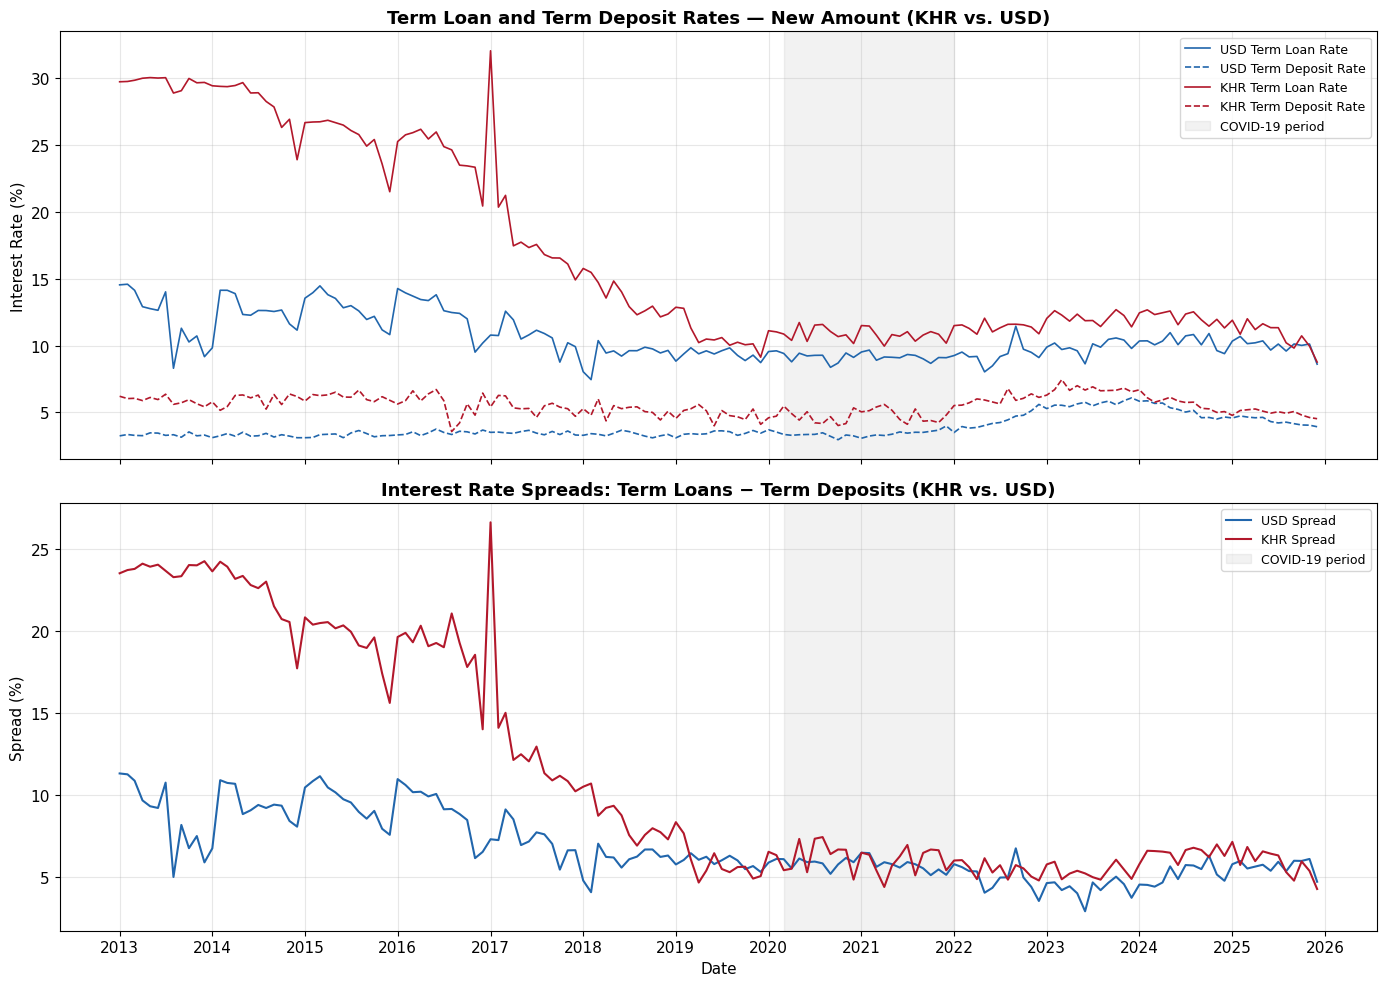


Figure saved: fig_preview_spreads.png


In [9]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Top panel: Raw rates ---
ax1 = axes[0]
ax1.plot(df_wide['Date'], df_wide['USD_Term_Loans'], label='USD Term Loan Rate', color='#2166ac', linewidth=1.2)
ax1.plot(df_wide['Date'], df_wide['USD_Term_Deposits'], label='USD Term Deposit Rate', color='#2166ac', linewidth=1.2, linestyle='--')
ax1.plot(df_wide['Date'], df_wide['KHR_Term_Loans'], label='KHR Term Loan Rate', color='#b2182b', linewidth=1.2)
ax1.plot(df_wide['Date'], df_wide['KHR_Term_Deposits'], label='KHR Term Deposit Rate', color='#b2182b', linewidth=1.2, linestyle='--')
ax1.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-12-31'), alpha=0.1, color='gray', label='COVID-19 period')
ax1.set_ylabel('Interest Rate (%)')
ax1.set_title('Term Loan and Term Deposit Rates — New Amount (KHR vs. USD)', fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)

# --- Bottom panel: Spreads ---
ax2 = axes[1]
ax2.plot(df_wide['Date'], df_wide['spread_usd'], label='USD Spread', color='#2166ac', linewidth=1.5)
ax2.plot(df_wide['Date'], df_wide['spread_khr'], label='KHR Spread', color='#b2182b', linewidth=1.5)
ax2.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-12-31'), alpha=0.1, color='gray', label='COVID-19 period')
ax2.set_ylabel('Spread (%)')
ax2.set_xlabel('Date')
ax2.set_title('Interest Rate Spreads: Term Loans − Term Deposits (KHR vs. USD)', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('fig_preview_spreads.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved: fig_preview_spreads.png")

## 6. Save Clean CSVs

We save two separate spread files (primary analysis) plus the full wide table for reference.

In [10]:
# --- Primary: USD Spread ---
df_usd = df_wide[['Date', 'USD_Term_Loans', 'USD_Term_Deposits', 'spread_usd']].copy()
df_usd.columns = ['date', 'term_loan_rate', 'term_deposit_rate', 'spread']
df_usd.to_csv('spreads_usd_new_amount.csv', index=False)
print(f"Saved: spreads_usd_new_amount.csv ({len(df_usd)} rows)")

# --- Primary: KHR Spread ---
df_khr = df_wide[['Date', 'KHR_Term_Loans', 'KHR_Term_Deposits', 'spread_khr']].copy()
df_khr.columns = ['date', 'term_loan_rate', 'term_deposit_rate', 'spread']
df_khr.to_csv('spreads_khr_new_amount.csv', index=False)
print(f"Saved: spreads_khr_new_amount.csv ({len(df_khr)} rows)")

# --- Full wide table (for reference) ---
df_wide.to_csv('all_rates_wide_new_amount.csv', index=False)
print(f"Saved: all_rates_wide_new_amount.csv ({len(df_wide)} rows)")

Saved: spreads_usd_new_amount.csv (156 rows)
Saved: spreads_khr_new_amount.csv (156 rows)
Saved: all_rates_wide_new_amount.csv (156 rows)


## 7. Robustness Data: Outstanding Amount Spreads

For the robustness section of the paper, we also prepare the Outstanding Amount version.

In [11]:
# ============================================================
# ROBUSTNESS: Weighted Average on Outstanding Amount
# ============================================================

rate_type_robust = 'Weighted Average on Outstanding Amount'

mask_robust = (
    (df['Rate_Type'] == rate_type_robust) &
    (df['Product'].isin(['Term Loans', 'Term Deposits']))
)
df_robust = df[mask_robust].copy()

# Pivot to wide
df_wide_robust = df_robust.pivot_table(
    index='Date',
    columns=['Currency', 'Product'],
    values='Value',
    aggfunc='first'
).sort_index()

df_wide_robust.columns = [f"{c}_{p.replace(' ', '_')}" for c, p in df_wide_robust.columns]
df_wide_robust = df_wide_robust.reset_index()

# Compute spreads
df_wide_robust['spread_usd'] = df_wide_robust['USD_Term_Loans'] - df_wide_robust['USD_Term_Deposits']
df_wide_robust['spread_khr'] = df_wide_robust['KHR_Term_Loans'] - df_wide_robust['KHR_Term_Deposits']

# Save
df_usd_robust = df_wide_robust[['Date', 'USD_Term_Loans', 'USD_Term_Deposits', 'spread_usd']].copy()
df_usd_robust.columns = ['date', 'term_loan_rate', 'term_deposit_rate', 'spread']
df_usd_robust.to_csv('spreads_usd_outstanding.csv', index=False)

df_khr_robust = df_wide_robust[['Date', 'KHR_Term_Loans', 'KHR_Term_Deposits', 'spread_khr']].copy()
df_khr_robust.columns = ['date', 'term_loan_rate', 'term_deposit_rate', 'spread']
df_khr_robust.to_csv('spreads_khr_outstanding.csv', index=False)

print(f"Saved: spreads_usd_outstanding.csv ({len(df_usd_robust)} rows)")
print(f"Saved: spreads_khr_outstanding.csv ({len(df_khr_robust)} rows)")

Saved: spreads_usd_outstanding.csv (156 rows)
Saved: spreads_khr_outstanding.csv (156 rows)


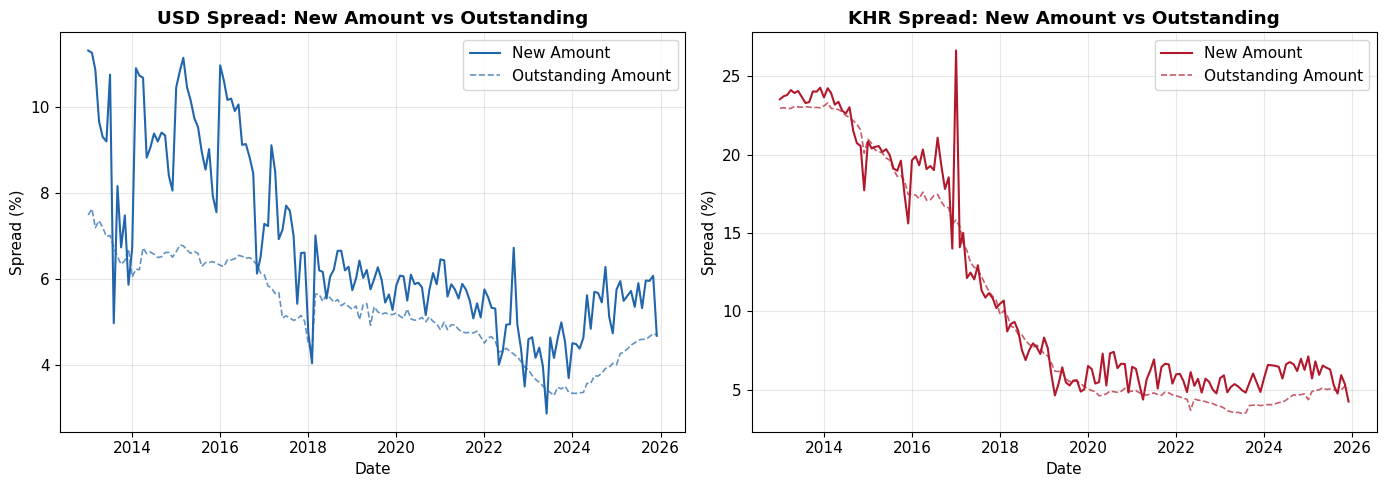


This comparison will be useful for your robustness section.


In [12]:
# Quick comparison: New Amount vs Outstanding Amount spreads
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# USD
axes[0].plot(df_wide['Date'], df_wide['spread_usd'], label='New Amount', color='#2166ac', linewidth=1.5)
axes[0].plot(df_wide_robust['Date'], df_wide_robust['spread_usd'], label='Outstanding Amount', color='#2166ac', linewidth=1.2, linestyle='--', alpha=0.7)
axes[0].set_title('USD Spread: New Amount vs Outstanding', fontweight='bold')
axes[0].set_ylabel('Spread (%)')
axes[0].set_xlabel('Date')
axes[0].legend()

# KHR
axes[1].plot(df_wide['Date'], df_wide['spread_khr'], label='New Amount', color='#b2182b', linewidth=1.5)
axes[1].plot(df_wide_robust['Date'], df_wide_robust['spread_khr'], label='Outstanding Amount', color='#b2182b', linewidth=1.2, linestyle='--', alpha=0.7)
axes[1].set_title('KHR Spread: New Amount vs Outstanding', fontweight='bold')
axes[1].set_ylabel('Spread (%)')
axes[1].set_xlabel('Date')
axes[1].legend()

for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('fig_new_vs_outstanding.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nThis comparison will be useful for your robustness section.")

## 8. Summary

### Files Created

| File | Description | Use |
|------|-------------|-----|
| `spreads_usd_new_amount.csv` | USD spread (primary) | Main analysis |
| `spreads_khr_new_amount.csv` | KHR spread (primary) | Main analysis |
| `spreads_usd_outstanding.csv` | USD spread (robustness) | Robustness check |
| `spreads_khr_outstanding.csv` | KHR spread (robustness) | Robustness check |
| `all_rates_wide_new_amount.csv` | All 4 rates + 2 spreads | Reference |

### Next Step

→ **Notebook 02: Exploratory Analysis** — Deeper statistical analysis, distribution plots, correlation analysis, and all figures needed for Section 4 (Data Description) of your paper.

In [13]:
# Final summary
print("=" * 60)
print("DATA PREPARATION COMPLETE")
print("=" * 60)
print(f"\nDate range: {df_wide['Date'].min().strftime('%Y-%m')} to {df_wide['Date'].max().strftime('%Y-%m')}")
print(f"Observations: {len(df_wide)} months (~{len(df_wide)//12} years)")
print(f"\nPrimary data: Weighted Average on New Amount")
print(f"Products: Term Loans − Term Deposits")
print(f"\nUSD spread — Mean: {df_wide['spread_usd'].mean():.2f}%  Std: {df_wide['spread_usd'].std():.2f}%")
print(f"KHR spread — Mean: {df_wide['spread_khr'].mean():.2f}%  Std: {df_wide['spread_khr'].std():.2f}%")
print(f"Correlation: {df_wide['spread_usd'].corr(df_wide['spread_khr']):.4f}")
print(f"\n✓ 6 CSV files saved")
print(f"✓ 2 preview figures saved")
print(f"\n→ Next: Notebook 02 (Exploratory Analysis)")

DATA PREPARATION COMPLETE

Date range: 2013-01 to 2025-12
Observations: 156 months (~13 years)

Primary data: Weighted Average on New Amount
Products: Term Loans − Term Deposits

USD spread — Mean: 6.72%  Std: 2.02%
KHR spread — Mean: 11.34%  Std: 7.11%
Correlation: 0.8387

✓ 6 CSV files saved
✓ 2 preview figures saved

→ Next: Notebook 02 (Exploratory Analysis)
